In [2]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


---
Use discrete dataset to prove EMD formula/pipeline works

__Data from DropSeq paper:__   
Macosko EZ, Basu A, Satija R, Nemesh J et al. Highly Parallel Genome-wide Expression Profiling of Individual Cells Using Nanoliter Droplets. Cell 2015 May 21;161(5):1202-1214. PMID: [26000488](https://www.ncbi.nlm.nih.gov/pubmed/26000488)

In [66]:
retina = RNA_counts.from_file(datafile='../resources/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1)

In [67]:
retina.data.shape

(6600, 20478)

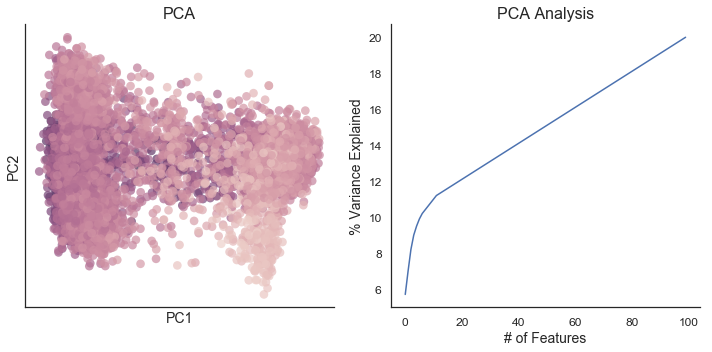

CPU times: user 28.8 s, sys: 3.7 s, total: 32.5 s
Wall time: 23.6 s


In [68]:
%%time
retina_PCA = fcc_PCA(matrix=retina.arcsinh_norm(norm='l1'), n_components=100)
retina_PCA.plot()

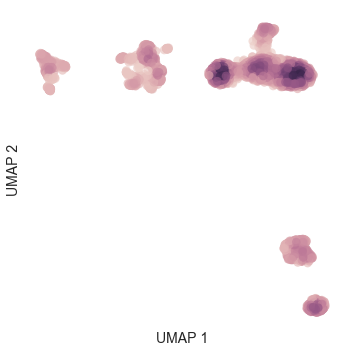

CPU times: user 22.1 s, sys: 1.53 s, total: 23.6 s
Wall time: 23.7 s


In [69]:
%%time
retina_UMAP = fcc_UMAP(matrix=retina_PCA.results,perplexity=30)
retina_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c9f06d8>)

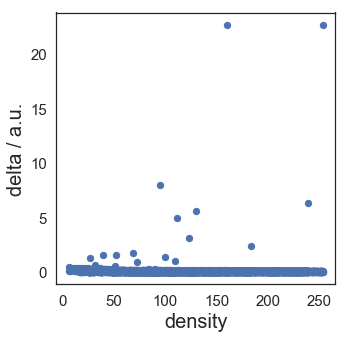

In [70]:
retina_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10c9e8908>)

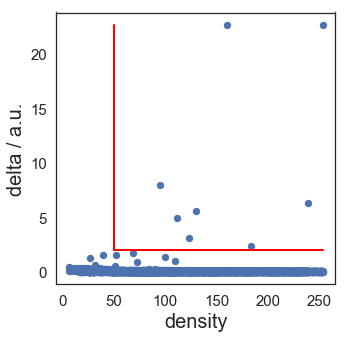

In [72]:
retina_UMAP.clu.assign(50,2)
retina_UMAP.clu.draw_decision_graph(min_delta=retina_UMAP.clu.min_delta, min_density=retina_UMAP.clu.min_density)

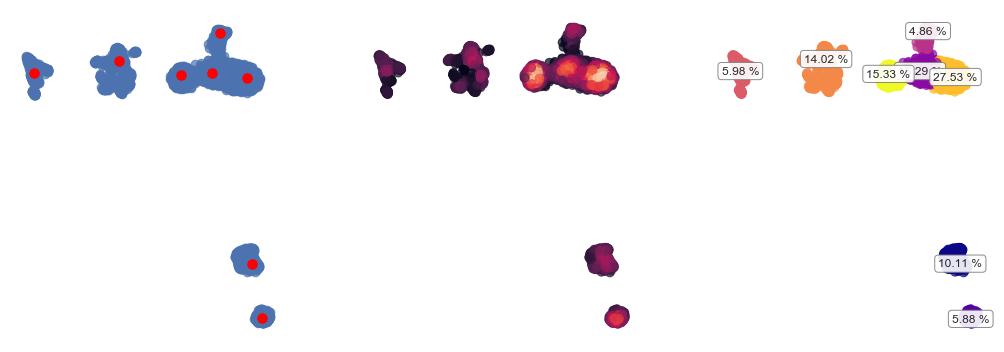

In [73]:
retina_UMAP.plot_clusters()

In [74]:
retina_UMAP.silhouette_score()

0.65223736

In [143]:
retina_ds = RNA_counts.downsample_proportional(retina, clu_membership=retina_UMAP.clu.membership, n_cells=1600, seed=18)

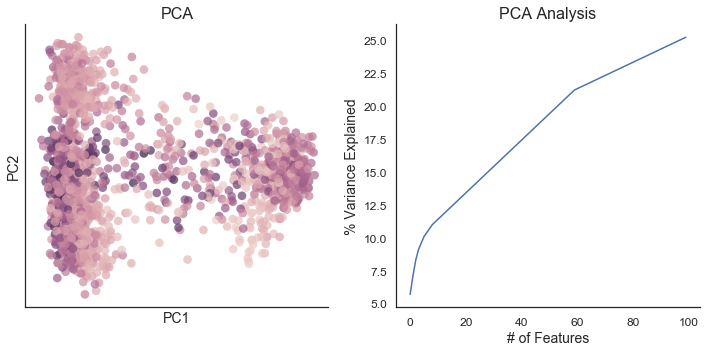

CPU times: user 7.33 s, sys: 955 ms, total: 8.28 s
Wall time: 5.12 s


In [144]:
%%time
retina_ds_PCA = fcc_PCA(matrix=retina_ds.arcsinh_norm(norm='l1'), n_components=100)
retina_ds_PCA.plot()

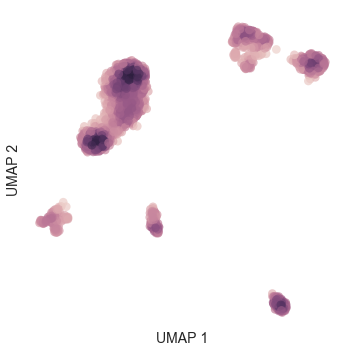

CPU times: user 4.03 s, sys: 226 ms, total: 4.26 s
Wall time: 4.06 s


In [145]:
%%time
retina_ds_UMAP = fcc_UMAP(matrix=retina_ds_PCA.results,perplexity=30)
retina_ds_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e0feac8>)

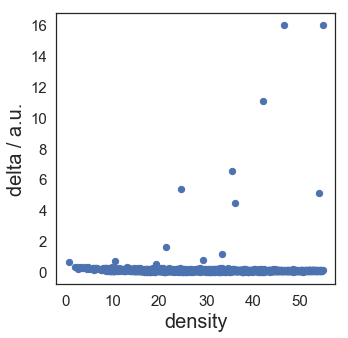

In [146]:
retina_ds_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ca18780>)

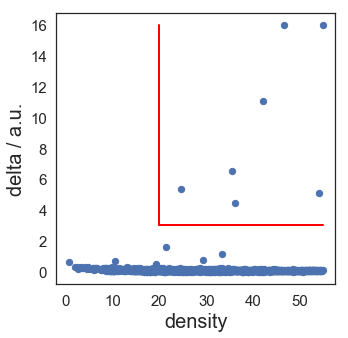

In [147]:
retina_ds_UMAP.clu.assign(20,3)
retina_ds_UMAP.clu.draw_decision_graph(min_delta=retina_ds_UMAP.clu.min_delta, min_density=retina_ds_UMAP.clu.min_density)

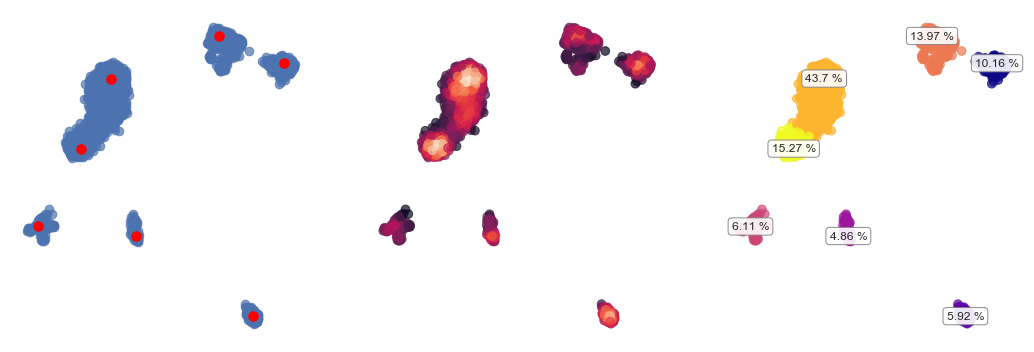

In [148]:
retina_ds_UMAP.plot_clusters()

In [149]:
retina_ds_UMAP.silhouette_score()

0.66469127

In [150]:
retina_ds_UMAP.cluster_counts()

163 cells in cluster 0 (10.162 %)

95 cells in cluster 1 (5.923 %)

78 cells in cluster 2 (4.863 %)

98 cells in cluster 3 (6.11 %)

224 cells in cluster 4 (13.965 %)

701 cells in cluster 5 (43.703 %)

245 cells in cluster 6 (15.274 %)



In [83]:
# set cluster membership as barcodes
retina_ds_UMAP.barcodes = pd.Series(retina_ds_UMAP.clu.membership)

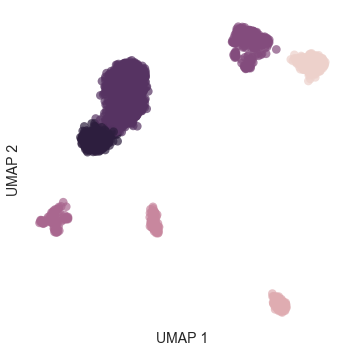

In [84]:
retina_ds_UMAP.plot_barcodes()

In [85]:
# set cluster membership as barcodes
retina_ds.barcodes = pd.Series(retina_ds_UMAP.clu.membership)

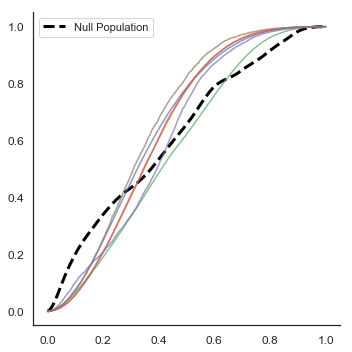

CPU times: user 2.92 s, sys: 210 ms, total: 3.13 s
Wall time: 2.97 s


In [86]:
%%time
# compare each cluster's cell-cell distances to the null population
retina_out = compare_barcode_distances(obj=retina_ds_UMAP, barcodes=[1,2,3,4,5,6])

In [87]:
%%time
# range of top clusters in retina dataset is 400 to 4200 cells. create 'standard curve' of n_cells to determine noise threshold. 
retina_curve = cell_bias_curve(obj=retina_ds_UMAP, pop_sizes=np.arange(50, 700, 50), iter=10)

CPU times: user 48.4 s, sys: 1.99 s, total: 50.4 s
Wall time: 50.7 s


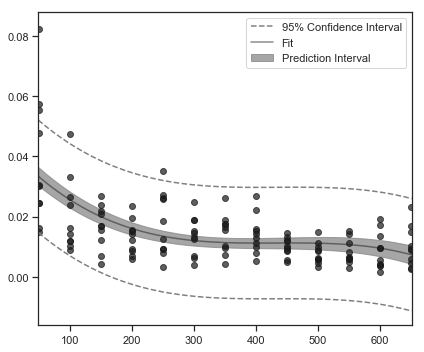

In [88]:
# plot polynomial regression
retina_p, retina_pi, retina_ci = easy_regression(x=retina_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y = retina_curve.melt(id_vars='n_cells')['value'], deg=3)

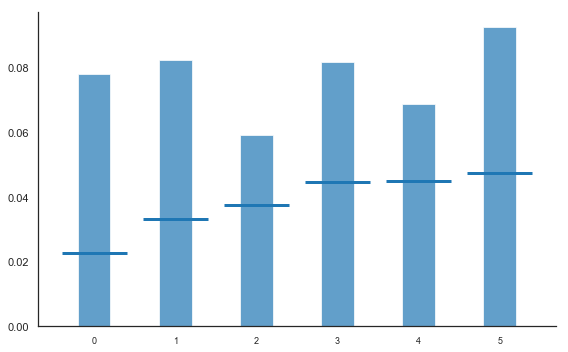

In [89]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(8,5))
plt.bar(x=[0,1,2,3,4,5], height=retina_out.EMD, width=-0.4, color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=retina_p, x=retina_ds.barcode_counts([0,1,2,3,4,5])) + regression_intervals(x=retina_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=retina_curve.melt(id_vars='n_cells')['value'],
                                  p=retina_p, x_range=list(retina_ds.barcode_counts([0,1,2,3,4,5])))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()

---
Now try the same thing for a continuous dataset by assigning random barcodes with proportional downsampling

__Data used in p-Creode paper:__   
Paul F, Arkin Y, Giladi A, Jaitin DA et al. Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors. Cell 2015 Dec 17;163(7):1663-77. PMID: [26627738](https://www.ncbi.nlm.nih.gov/pubmed/26627738)

In [107]:
s1 = RNA_counts.from_file(datafile='../resources/Myeloid_with_IDs.csv', labels=[None,0])

In [108]:
s1.data.shape

(4423, 171)

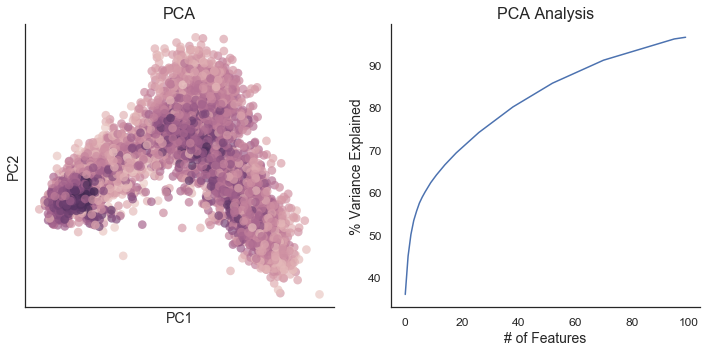

CPU times: user 3.31 s, sys: 226 ms, total: 3.54 s
Wall time: 3.05 s


In [109]:
%%time
# myeloid counts are already preprocessed and normalized. plug into PCA.
s1_PCA = fcc_PCA(matrix=s1.counts, n_components=100)
s1_PCA.plot()

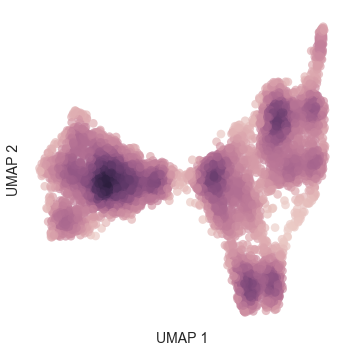

CPU times: user 15.2 s, sys: 599 ms, total: 15.8 s
Wall time: 15.4 s


In [110]:
%%time
# myeloid counts are already preprocessed and normalized. plug into UMAP.
s1_UMAP = fcc_UMAP(matrix=s1.counts,perplexity=30)
s1_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cad1320>)

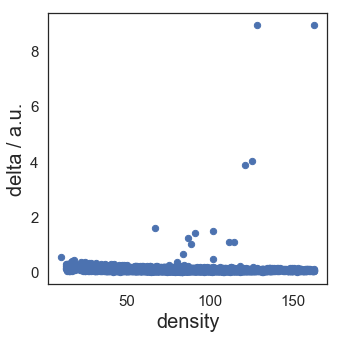

In [111]:
s1_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12df5d588>)

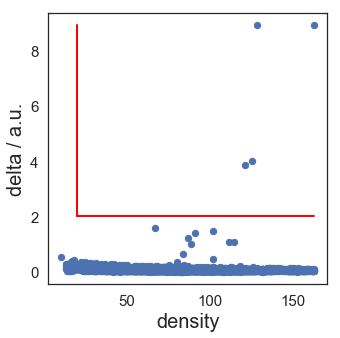

In [112]:
s1_UMAP.clu.assign(20,2)
s1_UMAP.clu.draw_decision_graph(min_delta=s1_UMAP.clu.min_delta, min_density=s1_UMAP.clu.min_density)

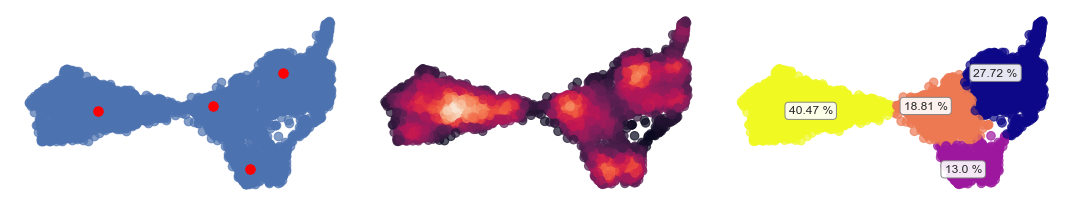

In [113]:
s1_UMAP.plot_clusters()

In [114]:
s1_UMAP.silhouette_score()

0.5570523

In [115]:
s1_UMAP.cluster_counts()

1226 cells in cluster 0 (27.719 %)

575 cells in cluster 1 (13.0 %)

832 cells in cluster 2 (18.811 %)

1790 cells in cluster 3 (40.47 %)



In [116]:
# set cluster membership as barcodes
s1_UMAP.barcodes = pd.Series(s1_UMAP.clu.membership)

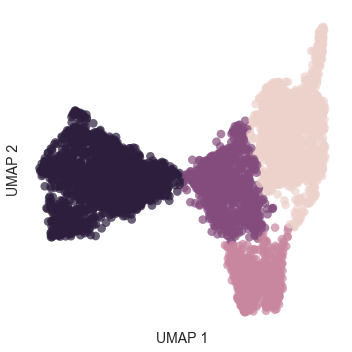

In [117]:
s1_UMAP.plot_barcodes()

In [118]:
# set cluster membership as barcodes
s1.barcodes = pd.Series(s1_UMAP.clu.membership)

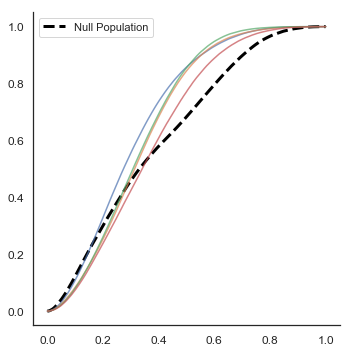

CPU times: user 18.8 s, sys: 1.83 s, total: 20.7 s
Wall time: 20.8 s


In [119]:
%%time
# compare each cluster's cell-cell distances to the null population
s1_out = compare_barcode_distances(obj=s1_UMAP, barcodes=[1,2,3,4])

In [120]:
%%time
# range of top clusters in retina dataset is 400 to 4200 cells. create 'standard curve' of n_cells to determine noise threshold. 
s1_curve = cell_bias_curve(obj=s1_UMAP, pop_sizes=np.arange(400, 1800, 200), iter=5)

CPU times: user 2min 17s, sys: 6.17 s, total: 2min 23s
Wall time: 2min 26s


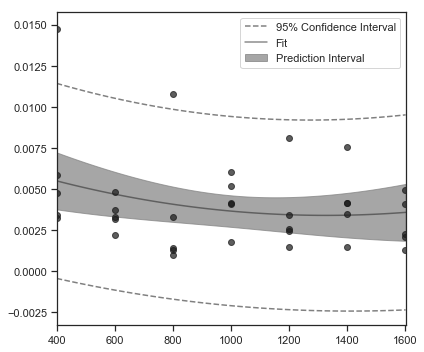

In [123]:
# plot polynomial regression
s1_p, s1_pi, s1_ci = easy_regression(x=s1_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y = s1_curve.melt(id_vars='n_cells')['value'], deg=2)

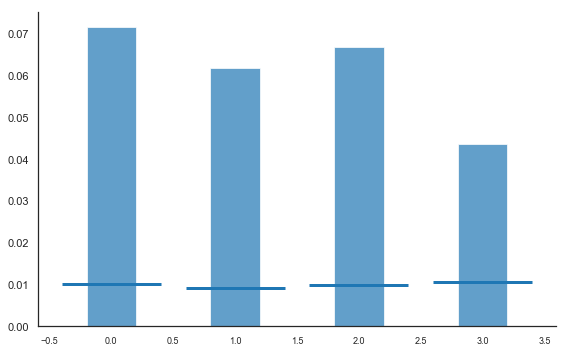

In [124]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(8,5))
plt.bar(x=[0,1,2,3], height=s1_out.EMD, width=-0.4, color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=s1_p, x=s1.barcode_counts([0,1,2,3])) + regression_intervals(x=s1_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=s1_curve.melt(id_vars='n_cells')['value'],
                                  p=s1_p, x_range=list(s1.barcode_counts([0,1,2,3])))[0], 
           xmin=np.arange(0,4)-0.4, xmax=np.arange(0,4)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()

---
Now choose random barcodes from the Myeloid set and perform calcs

In [126]:
s1.barcodes = None

In [127]:
s1_200 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=200)
s1_150 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=150)
s1_100 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=100)
s1_50 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=50)
s1_30 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=30)
s1_20 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=20)

In [128]:
s1_codes = np.zeros(s1.data.shape[0])

In [129]:
np.put(s1_codes, s1_200.data.index, 1)
np.put(s1_codes, s1_150.data.index, 2)
np.put(s1_codes, s1_100.data.index, 3)
np.put(s1_codes, s1_50.data.index, 4)
np.put(s1_codes, s1_30.data.index, 5)
np.put(s1_codes, s1_20.data.index, 6)

In [130]:
# set cluster membership as barcodes
s1_UMAP.barcodes = pd.Series(s1_codes, dtype='int')

In [131]:
# set cluster membership as barcodes
s1.barcodes = pd.Series(s1_codes, dtype='int')

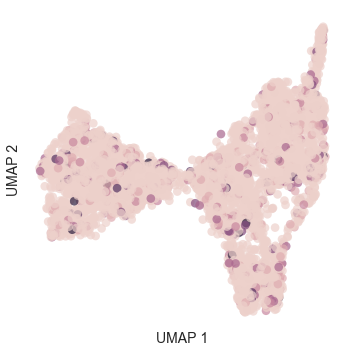

In [132]:
s1_UMAP.plot_barcodes()

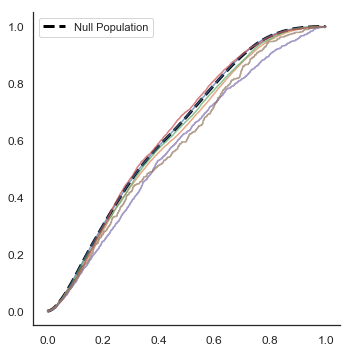

CPU times: user 28.2 s, sys: 1.61 s, total: 29.8 s
Wall time: 29.9 s


In [133]:
%%time
# compare each cluster's cell-cell distances to the null population
s1_out = compare_barcode_distances(obj=s1_UMAP, barcodes=[1,2,3,4,5,6])

In [134]:
%%time
# range of top clusters in s1 dataset is 20 to 200 cells. create 'standard curve' of n_cells to determine noise threshold. 
s1_curve = cell_bias_curve(obj=s1_UMAP, pop_sizes=np.arange(20, 200, 10), iter=10)

CPU times: user 10min 25s, sys: 16.3 s, total: 10min 42s
Wall time: 10min 49s


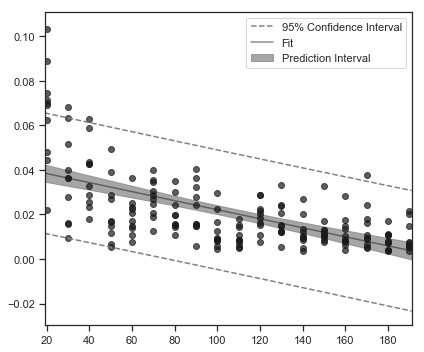

In [135]:
# plot polynomial regression
s1_p, s1_pi, s1_ci = easy_regression(x=s1_curve.melt(id_vars='n_cells')['n_cells'], y=s1_curve.melt(id_vars='n_cells')['value'], deg=1)

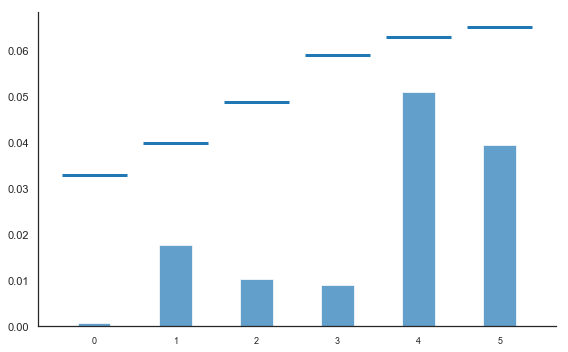

In [137]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(8,5))
plt.bar(x=[0,1,2,3,4,5], height=s1_out.EMD, width=-0.4, color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=s1_p, x=s1.barcode_counts([1,2,3,4,5,6])) + regression_intervals(x=s1_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=s1_curve.melt(id_vars='n_cells')['value'],
                                  p=s1_p, x_range=list(s1.barcode_counts([1,2,3,4,5,6])))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()